In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
def berry_cox_momentum(prices, lookback_period=12, holding_period=6):
    """
    Calculates the Berry-Cox price momentum factor
    :param prices: a Pandas DataFrame of historical prices
    :param lookback_period: the number of months to look back for calculating the momentum
    :param holding_period: the number of months to hold the position
    :return: a Pandas DataFrame of the Berry-Cox price momentum factor
    """
    # Calculate the percentage change in prices over the lookback period
    pct_change = prices.pct_change(periods=lookback_period)

    # Calculate the rolling geometric mean of the percentage change
    rolling_gmean = (1 + pct_change).rolling(window=lookback_period).apply(np.prod, raw=True) - 1

    # Calculate the cumulative return over the holding period
    cum_return = prices.pct_change(periods=holding_period).shift(-holding_period)

    # Calculate the Berry-Cox price momentum factor
    bc_factor = rolling_gmean.iloc[-1] * cum_return

    return bc_factor.dropna()

In [3]:
# Download historical prices for a set of stocks for backtesting
tickers = ["AAPL", "MSFT", "AMZN", "GOOG" , "NFLX"]
end_date = datetime.today()
n_years = 5
start_date = end_date - timedelta(days = n_years *365)

prices = yf.download(tickers = tickers, start=start_date, end=end_date)['Adj Close']

bc_factors = {}
for ticker in tickers:
    bc_factors[ticker] = berry_cox_momentum(prices[ticker])

# Combine the Berry-Cox factors into a single DataFrame
bc_factors_df = pd.concat(bc_factors, axis=1)
bc_factors_df.columns = tickers

#print the combined DataFrame
print(bc_factors_df)

[*********************100%***********************]  5 of 5 completed
                AAPL      MSFT      AMZN      GOOG      NFLX
Date                                                        
2018-05-14 -0.002513 -0.001462 -0.005889 -0.006126 -0.001640
2018-05-15  0.004918  0.024236  0.007648  0.000094 -0.009941
2018-05-16 -0.000076  0.015933  0.004659 -0.000517 -0.011213
2018-05-17  0.004061  0.030244  0.008406 -0.000601 -0.013981
2018-05-18  0.004075  0.022849  0.011452 -0.001253 -0.013746
...              ...       ...       ...       ...       ...
2023-04-27  0.014632  0.025477 -0.017740 -0.004399  0.001654
2023-04-28  0.010751  0.006036  0.001688  0.000041 -0.000677
2023-05-01  0.006139  0.006288  0.020972  0.000472 -0.004315
2023-05-02  0.014224  0.030147  0.029646  0.013149 -0.009815
2023-05-03  0.017582  0.025907  0.038225  0.022387 -0.013639

[1252 rows x 5 columns]


ranked_tickers
Date
2018-05-14    860.0
2018-05-15    582.0
2018-05-16    716.0
2018-05-17    571.0
2018-05-18    611.0
              ...  
2023-04-27    635.0
2023-04-28    647.0
2023-05-01    562.0
2023-05-02    258.0
2023-05-03    207.0
Name: mean_factor, Length: 1252, dtype: float64
long_tickers
DatetimeIndex(['2020-03-04', '2020-02-19'], dtype='datetime64[ns]', name='Date', freq=None)
short_tickers
DatetimeIndex(['2020-04-03', '2022-07-26'], dtype='datetime64[ns]', name='Date', freq=None)
Date
2018-05-14    1.0
2018-05-15    1.0
2018-05-16    1.0
2018-05-17    1.0
2018-05-18    1.0
dtype: float64
Date
2023-05-05    1.0
2023-05-08    1.0
2023-05-09    1.0
2023-05-10    1.0
2023-05-11    1.0
dtype: float64


<Axes: xlabel='Date'>

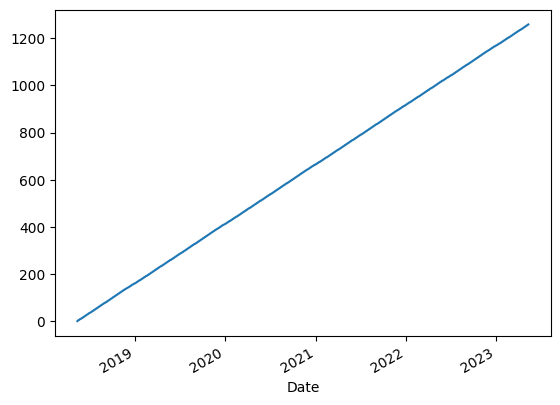

In [4]:
def long_short_portfolio(prices, lookback_period, holding_period, num_long, num_short):
    # Calculate the average Berry-Cox factor for each ticker
    bc_factors_df['mean_factor'] = bc_factors_df.mean(axis=1)

    # Rank the tickers based on the Berry-Cox factor
    ranked_tickers = bc_factors_df['mean_factor'].rank(ascending=False)

    print("ranked_tickers")
    print(ranked_tickers)


    # Select the top and bottom stocks
    long_tickers = ranked_tickers.nlargest(num_long, keep="all").index
    short_tickers = ranked_tickers.nsmallest(num_short, keep="all").index
    
    print("long_tickers")
    print(long_tickers)

    print("short_tickers")
    print(short_tickers)

    # Create an equally weighted long-short portfolio
    portfolio = pd.Series(0, index=prices.index)
    portfolio[long_tickers] = 1 / num_long
    portfolio[short_tickers] = -1 / num_short

    return portfolio

# Set the parameters for the long-short portfolio
lookback_period = 12
holding_period = 6
num_long = 2
num_short = 2

bc_factors_df['mean_factor'] = bc_factors_df.mean(axis=1)

# Rank the tickers based on the Berry-Cox factor
ranked_tickers = bc_factors_df['mean_factor'].rank(ascending=False)

# Select the top and bottom tickers for the long-short portfolio
num_holdings = 5 # number of assets to hold
long_tickers = ranked_tickers[ranked_tickers <= num_holdings].index.tolist()
short_tickers = ranked_tickers[ranked_tickers > len(tickers)-num_holdings].index.tolist()

# Create the long-short portfolio
portfolio = long_short_portfolio(prices, lookback_period, holding_period, num_long, num_short)

# Calculate the returns of the long-short portfolio
returns = (prices.pct_change() * portfolio.shift(1)).sum(axis=1)

# Calculate the cumulative returns of the long-short portfolio
cumulative_returns = (1 + returns).cumprod()

# Print the cumulative returns of the long-short portfolio
print(cumulative_returns.head())
print(cumulative_returns.tail())

# Plot the portfolio returns
cumulative_returns.cumsum().plot()

C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


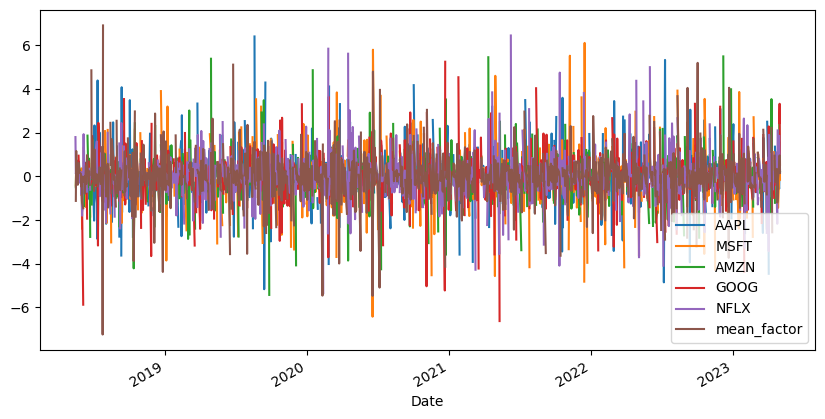

In [5]:
#Daily_returns
stock_log_returns = np.log(bc_factors_df/bc_factors_df.shift(1))
average_log_return = stock_log_returns.mean(1)

stock_log_returns.plot(figsize=(10,5))
plt.show()

In [6]:
#stock_allocation
weights = stock_log_returns.sub(average_log_return, axis=0) * -1.0
absolute_weights = weights.abs()
absolute_weights_sum = np.sum(absolute_weights, axis=1)
adjusted_weights = weights.div(absolute_weights_sum, axis=0).dropna()

In [7]:
adjusted_weights.head()

,AAPL,MSFT,AMZN,GOOG,NFLX,mean_factor
Date,,,,,,
2018-05-18,0.052948,0.218917,-0.125677,-0.374323,0.064966,0.163169
2018-05-24,-0.237435,-0.058712,-0.049832,-0.018618,0.500000,-0.135403
2018-05-25,-0.161491,0.124651,-0.338509,0.278005,0.097145,0.000198
2018-05-29,-0.244883,-0.025085,0.443628,-0.102497,-0.127536,0.056372
2018-05-30,-0.283662,0.255696,-0.127294,-0.089045,0.237649,0.006655
